<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


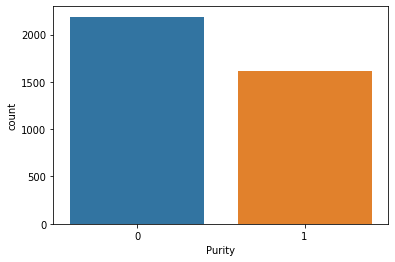

In [56]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

sns.countplot(x ='Purity', data = df)
plt.show()

In [57]:
df.columns

Index(['dates', '% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       '% Iron Concentrate', '% Silica Concentrate', 'Purity'],
      dtype='object')

In [58]:
features = ['% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       '% Iron Concentrate']

label = '% Silica Concentrate'
test_df = df[df['dates'] >= '2017-07-01']
train_df = df[df['dates'] < '2017-07-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [68]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=300, learning_rate=0.01, objective ='reg:linear', verbosity = 0)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
test_df = test_df.reset_index().drop('index', axis=1)
test_df['xgboost_predictions'] = pd.Series(predictions)

Test RMSE: 0.729


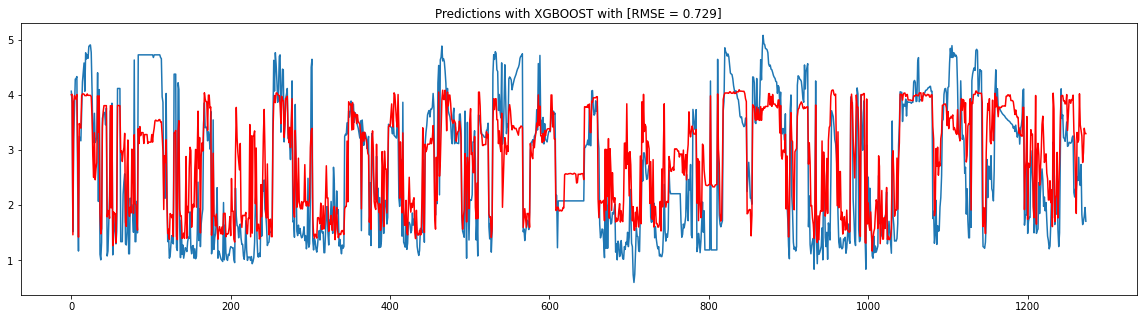

In [73]:
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test_df['% Silica Concentrate'], predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test_df['% Silica Concentrate'])
pyplot.plot(predictions, color='red')
plt.title("Predictions with XGBOOST with [RMSE = %.3f]" % rmse)
pyplot.show()

In [74]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100,
                                 max_features=1, oob_score=True)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
test_df = test_df.reset_index().drop('index', axis=1)
test_df['randomeForest_predictions'] = pd.Series(predictions)

Test RMSE: 0.729


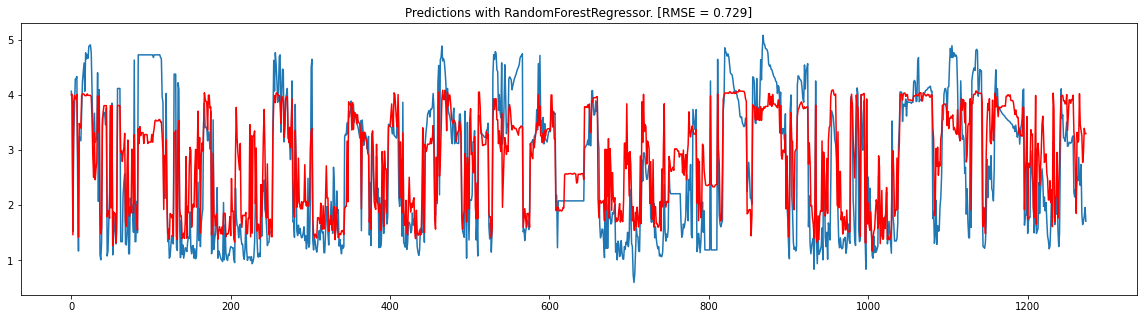

In [72]:
fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test_df['% Silica Concentrate'], predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test_df['% Silica Concentrate'])
pyplot.plot(predictions, color='red')
plt.title("Predictions with RandomForestRegressor [RMSE = %.3f]" % rmse)
pyplot.show()

In [63]:
test_df

,dates,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate,Purity,xgboost_predictions,randomeForest_predictions
0,2017-07-01 00:00:00,25.870000,579.474317,299.991372,299.898356,299.931400,500.958522,501.289239,62.810000,4.070000,0,4.006016,3.729500
1,2017-07-01 01:30:00,22.744572,563.119913,299.977774,299.927628,299.964582,500.772124,500.744856,63.060837,3.851772,0,4.013680,3.754263
2,2017-07-01 04:00:00,13.410000,541.428782,299.999922,300.020933,299.932045,499.204101,509.422006,66.150000,1.520000,1,1.464653,2.038699
3,2017-07-01 06:00:00,13.410000,514.274967,299.937161,300.015056,300.063683,500.215417,499.118972,63.810000,3.200000,0,3.878405,3.748788
4,2017-07-01 06:30:00,25.342148,559.058859,299.906693,299.871017,299.900842,500.931269,501.061663,63.307252,3.756349,0,3.990752,3.640547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,2017-09-09 19:00:00,23.200000,498.785884,301.432594,299.756449,299.929000,497.870623,409.189681,65.050000,1.650000,1,2.776149,2.730883
1270,2017-09-09 20:00:00,23.200000,510.780566,300.181000,299.593867,299.526313,498.402434,392.437663,64.830000,1.710000,1,2.953232,2.826026
1271,2017-09-09 21:00:00,23.200000,519.289535,299.419465,299.995958,299.767268,500.891915,459.091225,64.290000,1.800000,1,3.397832,3.622899
1272,2017-09-09 22:00:00,23.200000,493.451375,299.738536,299.809750,299.995732,494.662857,830.694840,64.250000,1.960000,1,3.301203,3.225608
